# WSI - laboratorium 5

Zadanie: "Sztuczne sieci neuronowe"

Autorzy: Michał Brus (299106) i Jakub Mazurkiewicz (300226)

## Wczytywanie zbioru MNIST

### Klasa bazowa

Poniższa klasa jest klasą bazową dla zbiorów obrazów ręcznie rysowanych cyfr o rozmiarach 8x8.

In [1]:
class MnistSetBase:
    def __init__(self):
        self.training_set = []
        self.validating_set = []
        self.testing_set = []

    def get_training_set(self):
        return self.training_set

    def get_validating_set(self):
        return self.validating_set

    def get_testing_set(self):
        return self.training_set

### Zbiór obrazów 8x8

Zbiór obrazów 8x8 pochodzi z pakietu `sklearn`.

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

class MnistSet8(MnistSetBase):
    def __init__(self):
        digits = load_digits()
        images = [(self._adjust_pixels(pixels), label) for pixels, label in zip(digits.data, digits.target)]
        self.training_set, self.testing_set = train_test_split(images)
        self.training_set, self.validating_set = train_test_split(self.training_set)

    def _adjust_pixels(self, pixels):
        return [pixel / 16 for pixel in pixels]

## Przygotowanie sztucznej sieci neuronowej

### Przyjęte funkcje aktywacji

In [3]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Przyjęte funkcje straty

In [4]:
def loss(predicted_y, expected_y):
    return np.square(predicted_y - expected_y)

def loss_derivative(predicted_y, expected_y):
    return 2 * (predicted_y - expected_y)

### Klasa reprezentująca sztuczną sieć neuronową

In [5]:
from numpy.random import default_rng

def chunks(r, n):
    for i in range(0, len(r), n):
        yield r[i:i+n]

class Network:
    def __init__(self, neurons_per_layer):
        self.number_of_layers = len(neurons_per_layer)
        self.neurons_per_layer = neurons_per_layer
        self.rng = default_rng()
        inv_sqrt_first_layer_size = 1 / np.sqrt(neurons_per_layer[0])
        self.biases = [self.rng.uniform(-inv_sqrt_first_layer_size, inv_sqrt_first_layer_size, size=(y, 1))
                       for y in neurons_per_layer[1:]]
        self.weights = [self.rng.uniform(-inv_sqrt_first_layer_size, inv_sqrt_first_layer_size, size=(y, x))
                        for x, y in zip(neurons_per_layer[:-1], neurons_per_layer[1:])]

    def feedforward(self, a):
        a = np.reshape(a, (-1, 1))
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def sgd(self, training_data, mini_batch_size, learning_rate):
        n = len(training_data)
        self.rng.shuffle(training_data)
        mini_batches = chunks(training_data, mini_batch_size)
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, learning_rate)

    def update_mini_batch(self, mini_batch, learning_rate):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(np.reshape(x, (-1, 1)), y)
            nabla_b = [nb + d_nb for nb, d_nb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + d_nw for nw, d_nw in zip(nabla_w, delta_nabla_w)]
        self.biases = [b - (nb * learning_rate / len(mini_batch)) for b, nb in zip(self.biases, nabla_b)]
        self.weights = [w - (nw * learning_rate / len(mini_batch)) for w, nw in zip(self.weights, nabla_w)]

    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        z_vectors = []
        for b, w in zip(self.biases, self.weights):
            z_vector = np.dot(w, activation) + b
            z_vectors.append(z_vector)
            activation = sigmoid(z_vector)
            activations.append(activation)
        delta = loss_derivative(activations[-1], self.one_hot_encode(y)) * sigmoid_derivative(z_vectors[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, np.transpose(activations[-2]))

        for i in range(2, self.number_of_layers):
            z_vector = z_vectors[-i]
            delta = np.dot(self.weights[-i + 1].transpose(), delta) * sigmoid_derivative(z_vector)
            nabla_b[-i] = delta
            nabla_w[-i] = np.dot(delta, np.transpose(activations[-i - 1]))
        return nabla_b, nabla_w

    def evaluate(self, data_set):
        results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data_set]
        return sum(int(x == y) for (x, y) in results)

    def mse(self, test_data):
        err = [loss(self.feedforward(x), self.one_hot_encode(y)) for (x, y) in test_data]
        mean_err = np.mean(err)
        return mean_err

    def one_hot_encode(self, j):
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e

## Eksperymenty na zbiorze walidacyjnym

### Funkcja wspomagająca przeprowadzanie eksperymentów

Poniższa funkcja wspomaga przeprowadzanie eksperymentów z wykorzystaniem zbioru walidacyjnego. Pomoże ona w doborze odpowiednich hiperparametrów algorytmu (dających jak najlepsze rezultaty).

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def simulation(network_layers, epochs, mini_batch_size, learning_rate):
    network = Network(network_layers)
    accuracy_history = []
    mse_history = []
    
    print('Starting simulation', end='', flush=True)
    for i in range(epochs):
        network.sgd(training_set, mini_batch_size, learning_rate)
        accuracy_history.append(round(network.evaluate(validating_set) / len(validating_set) * 100, 2))
        mse_history.append(round(network.mse(validating_set), 5))
        print('.', end='', flush=True)
    
    print('')
    epochs_list = [f'Epoch {i+1}' for i in range(epochs)]
    data = np.transpose([epochs_list, accuracy_history, mse_history])
    print(pd.DataFrame(data, columns=['Epoch', 'Accuracy', 'MSE']))
    plt.figure()
    plt.plot(range(1, epochs+1), accuracy_history)
    plt.scatter(range(1, epochs+1), accuracy_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Procent poprawnych predykcji')
    plt.title('Poprawne predykcje w zależności od epoki')
    plt.grid(True)
    plt.figure()
    plt.plot(range(1, epochs+1), mse_history)
    plt.scatter(range(1, epochs+1), mse_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Błąd średniokwadratowy')
    plt.title('Błąd średniokwadratowy w zależności od epoki')
    plt.grid(True)
    plt.show()

### Załadowanie zbioru

In [7]:
mnist = MnistSet8()
training_set = mnist.get_training_set()
validating_set = mnist.get_validating_set()
testing_set = mnist.get_testing_set()

### Eksperyment 1 - wstępnie dobrane hiperparametry

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1    12.17  0.09037
1    Epoch 2     7.72  0.09054
2    Epoch 3     8.61  0.09039
3    Epoch 4    10.98  0.09005
4    Epoch 5     7.72  0.09049
5    Epoch 6    12.17  0.09018
6    Epoch 7    14.84  0.08996
7    Epoch 8    17.21  0.08848
8    Epoch 9    22.85  0.08224
9   Epoch 10    30.56     0.08
10  Epoch 11    37.98  0.07321
11  Epoch 12    42.14  0.06716
12  Epoch 13    46.88  0.06277
13  Epoch 14    51.34  0.06254
14  Epoch 15    59.05  0.05218
15  Epoch 16    62.91  0.04742
16  Epoch 17    71.51  0.04434
17  Epoch 18    78.93  0.03632
18  Epoch 19    79.53  0.03259
19  Epoch 20    87.24  0.02533
20  Epoch 21    87.24  0.02582
21  Epoch 22    89.02  0.02059
22  Epoch 23    88.43  0.01916
23  Epoch 24    93.18  0.01476
24  Epoch 25    92.88  0.01372
25  Epoch 26    91.39  0.01374
26  Epoch 27    91.69  0.01357
27  Epoch 28    94.66  0.01096
28  Epoch 29    94.07   0.0104
29  Epoch 30    94.9

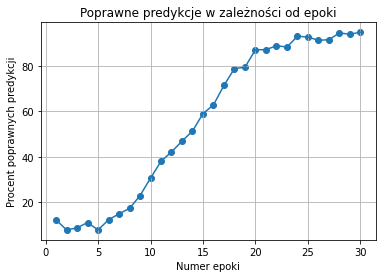

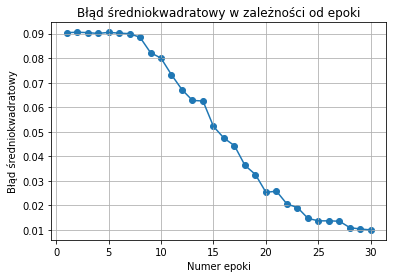

In [8]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=10, learning_rate=1.5)

W powyższym ekperymencie widać, że model już w trzydziestej epoce prawidłowo rozpoznawał ponad 94% wejściowych obrazów.

### Eksperyment 2 - zwiększenie parametru `learning_rate`

W tym eksperymentcie parametr `learning_rate` został zwiększony z 1.5 do 3.0.

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1    13.35  0.09029
1    Epoch 2     8.61  0.09115
2    Epoch 3     8.61  0.09076
3    Epoch 4    18.99  0.09022
4    Epoch 5     9.79   0.0887
5    Epoch 6    19.58   0.0822
6    Epoch 7    34.42  0.07852
7    Epoch 8    49.26  0.06566
8    Epoch 9    55.79  0.05337
9   Epoch 10     72.4  0.03932
10  Epoch 11    81.31   0.0289
11  Epoch 12    82.49  0.02672
12  Epoch 13    86.65  0.02186
13  Epoch 14    92.88  0.01422
14  Epoch 15    92.58  0.01307
15  Epoch 16    93.47   0.0112
16  Epoch 17    92.58  0.01118
17  Epoch 18    93.77  0.01079
18  Epoch 19     90.8  0.01316
19  Epoch 20    96.14  0.00714
20  Epoch 21    95.85  0.00793
21  Epoch 22    93.47     0.01
22  Epoch 23    97.03  0.00519
23  Epoch 24    92.88  0.00931
24  Epoch 25    96.74  0.00564
25  Epoch 26    97.33  0.00609
26  Epoch 27    97.33  0.00448
27  Epoch 28    97.63  0.00533
28  Epoch 29    97.33  0.00518
29  Epoch 30    97.9

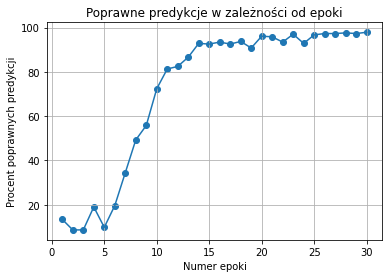

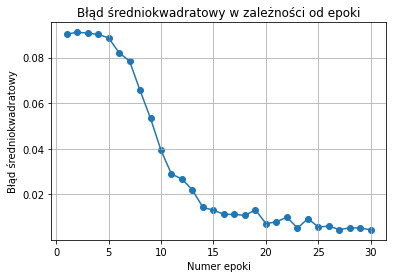

In [9]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=10, learning_rate=3.0)

Powyższy eksperyment pokazał, że zwiększenie parametru `learning_rate` wpłynęło na szybsze osiągnięcie dobrego rozpoznawania obrazów - w trzydziestej epoce rozpoznanych poprawie zostało ponad 97% obrazów.

### Eksperyment 3 - ponowne zwiększenie parametru `learning_rate`

W tym eksperymentcie parametr `learning_rate` został zwiększony z 3.0 do 6.0.

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1     8.61  0.09022
1    Epoch 2    10.09   0.0904
2    Epoch 3     18.4  0.08844
3    Epoch 4    28.78  0.08367
4    Epoch 5    41.54  0.07027
5    Epoch 6    42.73  0.06347
6    Epoch 7    67.66  0.04394
7    Epoch 8    70.33  0.03584
8    Epoch 9     81.9  0.02391
9   Epoch 10    91.69  0.01666
10  Epoch 11    93.18  0.01069
11  Epoch 12    91.99  0.01254
12  Epoch 13    74.18  0.03928
13  Epoch 14    93.18   0.0096
14  Epoch 15    94.66  0.00839
15  Epoch 16    94.36  0.00904
16  Epoch 17    93.77  0.01012
17  Epoch 18    93.47  0.01095
18  Epoch 19    86.65  0.02295
19  Epoch 20    94.07   0.0104
20  Epoch 21    97.03  0.00555
21  Epoch 22    95.25   0.0082
22  Epoch 23    95.25  0.00618
23  Epoch 24    95.25  0.00882
24  Epoch 25    97.33  0.00502
25  Epoch 26    95.25   0.0074
26  Epoch 27    97.63  0.00414
27  Epoch 28    85.46  0.02424
28  Epoch 29    93.77  0.01122
29  Epoch 30    97.9

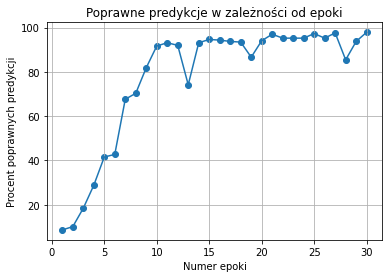

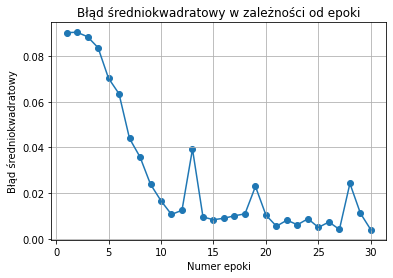

In [22]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=10, learning_rate=6.0)

Wniosek: ponowne zwiększenie parametru `learning_rate` nie wpłynęło na jakość predykcji.

### Eksperyment 4 - zmniejszenie rozmiaru próby danych (`mini_batch_size`)

W tym eksperymencie parametr `mini_batch_size` został zmniejszony z pierwotnej wartości 10 do 5.

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1     8.61  0.09094
1    Epoch 2     7.72  0.09062
2    Epoch 3      8.9  0.09015
3    Epoch 4    16.62  0.08978
4    Epoch 5     45.4  0.06843
5    Epoch 6    68.25  0.04824
6    Epoch 7    78.64  0.03298
7    Epoch 8    88.43  0.02208
8    Epoch 9    93.47  0.01388
9   Epoch 10    92.58  0.01263
10  Epoch 11    89.32  0.01645
11  Epoch 12    94.96  0.01049
12  Epoch 13    96.74  0.00587
13  Epoch 14    93.77  0.00954
14  Epoch 15    94.96  0.00895
15  Epoch 16    95.25   0.0071
16  Epoch 17    94.66  0.00897
17  Epoch 18    92.58  0.01054
18  Epoch 19    94.96  0.00809
19  Epoch 20    94.36  0.00934
20  Epoch 21    93.77  0.00779
21  Epoch 22    95.55  0.00747
22  Epoch 23    97.03  0.00605
23  Epoch 24    95.55  0.00651
24  Epoch 25    95.85  0.00601
25  Epoch 26    97.03  0.00504
26  Epoch 27    97.03  0.00523
27  Epoch 28    97.33  0.00428
28  Epoch 29    97.92  0.00439
29  Epoch 30    97.9

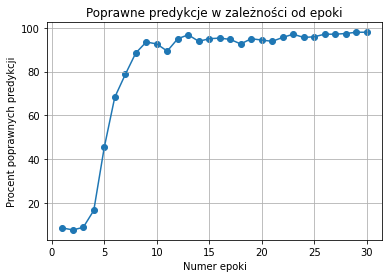

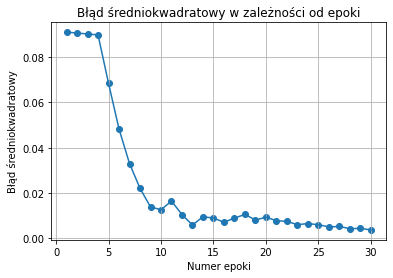

In [27]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=5, learning_rate=3.0)

Wniosek: zmniejszenie wartości parametru `mini_batch_size` wpłynęło pozytywanie na szybkość uczenia - już w dziewiątej epoce model osiągnął wynik powyżej 90%.

### Eksperyment 5 - zwiększenie ilości epok

W tym eksperymecie ilość epok została zwiększona do pięćdziesięciu.

Starting simulation..................................................
       Epoch Accuracy      MSE
0    Epoch 1      8.9  0.09087
1    Epoch 2     7.72  0.09185
2    Epoch 3     18.1  0.08909
3    Epoch 4    22.55   0.0828
4    Epoch 5    34.72  0.07212
5    Epoch 6    43.62  0.06278
6    Epoch 7    62.61  0.04624
7    Epoch 8    75.37  0.03512
8    Epoch 9    80.12  0.02647
9   Epoch 10     90.5  0.01737
10  Epoch 11    91.69  0.01433
11  Epoch 12    89.61  0.01616
12  Epoch 13    89.61  0.01469
13  Epoch 14    93.77  0.00901
14  Epoch 15    95.85  0.00765
15  Epoch 16    95.85   0.0084
16  Epoch 17    93.18  0.01013
17  Epoch 18    95.25  0.00829
18  Epoch 19    96.44  0.00755
19  Epoch 20    93.18  0.01167
20  Epoch 21    95.25  0.00787
21  Epoch 22    95.55  0.00741
22  Epoch 23    95.25  0.00815
23  Epoch 24    97.63  0.00543
24  Epoch 25    95.55  0.00704
25  Epoch 26    95.25   0.0078
26  Epoch 27    93.77  0.01015
27  Epoch 28    96.74  0.00601
28  Epoch 29    96.14  0.00628


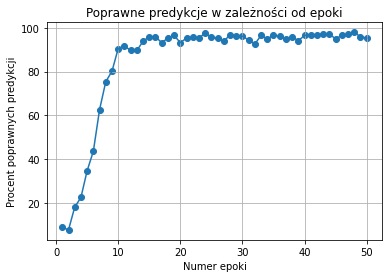

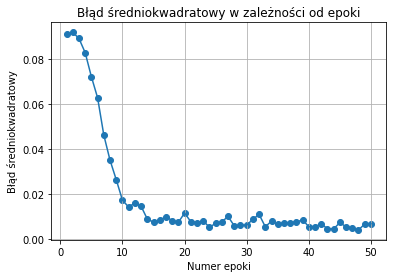

In [25]:
simulation(network_layers=[64, 16, 16, 10], epochs=50, mini_batch_size=5, learning_rate=3.0)

Wniosek: zwiększnie ilości epok nie wpłynęło na jakość modelu - osiągana ilość poprawnych predykcji utrzymuje się na poziomie ok. 96%.

### Eksperyment 6 - zmniejszenie wartości `learning_rate`

Celem tego eksperymentu jest sprawdzenie jak bardzo mała wartość parametru `learning_rate` wpływa na jakość modelu.

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1    10.98  0.21236
1    Epoch 2    10.98  0.18636
2    Epoch 3    10.98  0.16645
3    Epoch 4    10.98  0.15122
4    Epoch 5    10.98  0.13953
5    Epoch 6    10.98  0.13048
6    Epoch 7    10.98  0.12342
7    Epoch 8    10.98  0.11785
8    Epoch 9     6.53  0.11342
9   Epoch 10      9.5  0.10985
10  Epoch 11      9.5  0.10696
11  Epoch 12      9.5  0.10459
12  Epoch 13      9.5  0.10263
13  Epoch 14      9.5    0.101
14  Epoch 15      9.5  0.09963
15  Epoch 16      9.5  0.09847
16  Epoch 17      9.5  0.09749
17  Epoch 18      9.5  0.09664
18  Epoch 19    11.57  0.09592
19  Epoch 20    10.98   0.0953
20  Epoch 21     8.61  0.09475
21  Epoch 22     8.61  0.09428
22  Epoch 23     8.61  0.09387
23  Epoch 24     8.61   0.0935
24  Epoch 25     8.61  0.09318
25  Epoch 26     8.61   0.0929
26  Epoch 27     8.61  0.09264
27  Epoch 28     8.61  0.09242
28  Epoch 29     8.61  0.09222
29  Epoch 30     8.6

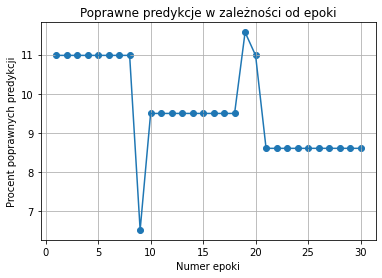

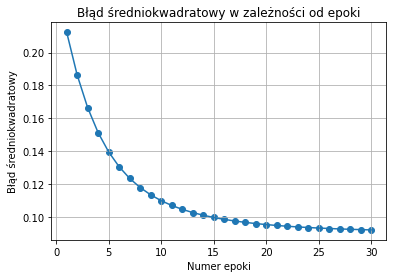

In [30]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=5, learning_rate=0.001)

Wniosek: zbyt mały `learning_rate` sprawia, że model osiąga bardzo słabe wyniki. Ilość poprawnych predykcji nie przekroczyła nawet 10%.

### Testowanie modelu z danymi z grupy testowej

Uzyskane hiperparametry z poprzednich pięciu eksperymentów:

* Ilość epok: 30
* Rozmiar próby: 5
* Parametr `learning_rate`: 3.0

Starting simulation..............................
       Epoch Accuracy      MSE
0    Epoch 1    10.89  0.09088
1    Epoch 2      9.5  0.09049
2    Epoch 3    11.09  0.09004
3    Epoch 4    28.81  0.08387
4    Epoch 5    50.59  0.06187
5    Epoch 6     60.1  0.05045
6    Epoch 7    72.57    0.039
7    Epoch 8    73.17  0.03494
8    Epoch 9    83.66  0.02495
9   Epoch 10     90.5  0.01618
10  Epoch 11    93.76  0.01003
11  Epoch 12    96.24  0.00644
12  Epoch 13    94.46  0.00901
13  Epoch 14    95.05  0.00841
14  Epoch 15    95.94   0.0076
15  Epoch 16    96.34  0.00683
16  Epoch 17    98.12  0.00347
17  Epoch 18    98.32   0.0034
18  Epoch 19    96.83  0.00554
19  Epoch 20    97.03  0.00453
20  Epoch 21    94.65  0.00848
21  Epoch 22    99.01   0.0021
22  Epoch 23    99.11  0.00174
23  Epoch 24    98.71  0.00239
24  Epoch 25    99.21  0.00171
25  Epoch 26    98.22  0.00271
26  Epoch 27    97.92  0.00317
27  Epoch 28    99.41   0.0013
28  Epoch 29     99.5  0.00109
29  Epoch 30     99.

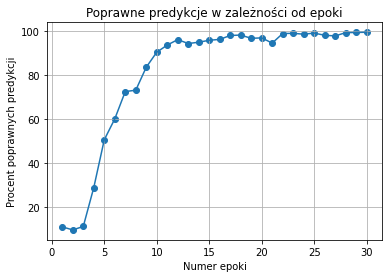

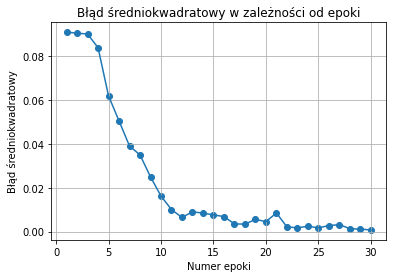

In [13]:
def mnist8_test():
    EPOCHS = 30
    network = Network([64, 16, 16, 10])
    accuracy_history = []
    mse_history = []
    
    print('Starting simulation', end='', flush=True)
    for i in range(EPOCHS):
        network.sgd(training_set, 5, 3.0)
        accuracy_history.append(round(network.evaluate(testing_set) / len(testing_set) * 100, 2))
        mse_history.append(round(network.mse(testing_set), 5))
        print('.', end='', flush=True)
    
    print('')
    epochs_list = [f'Epoch {i+1}' for i in range(EPOCHS)]
    data = np.transpose([epochs_list, accuracy_history, mse_history])
    print(pd.DataFrame(data, columns=['Epoch', 'Accuracy', 'MSE']))
    plt.figure()
    plt.plot(range(1, EPOCHS+1), accuracy_history)
    plt.scatter(range(1, EPOCHS+1), accuracy_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Procent poprawnych predykcji')
    plt.title('Poprawne predykcje w zależności od epoki')
    plt.grid(True)
    plt.figure()
    plt.plot(range(1, EPOCHS+1), mse_history)
    plt.scatter(range(1, EPOCHS+1), mse_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Błąd średniokwadratowy')
    plt.title('Błąd średniokwadratowy w zależności od epoki')
    plt.grid(True)
    plt.show()
    
mnist8_test()

Dobrane z wykorzystaniem zbioru walidacyjnego hiperparametry pozwoliły na uzyskanie bardzo dobrych wyników na zbiorze testowym. Algorytm dokonuje ponad 99% poprawnych predykcji.

## Podsumowanie

Hiperparametrem, który miał największy wpływ na jakość modelu był `learning_rate`. Zbyt mała jego wartość prowadziła do wolniejszego uczenia.